In [ ]:
%pip install -r ../requirements.txt

#### Imports

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from qbstyles import mpl_style

mpl_style(dark=True)

In [3]:
# Define paths to gunshot and non-gunshot data
GUNSHOT_PATH = "../data/gunshots/"
NON_GUNSHOT_PATH = "../data/non_gunshots/"

#### Data Pre-processing

In [11]:
def audio_to_spectrogram(audio, sample_rate=22050, n_mels=128, fixed_length=128):
    """
    Convert raw audio to a log-Mel spectrogram and ensure a fixed length.
    """
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    
    # Pad or truncate to fixed length
    if log_spectrogram.shape[1] < fixed_length:
        # Pad with zeros
        pad_width = fixed_length - log_spectrogram.shape[1]
        log_spectrogram = np.pad(log_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncate
        log_spectrogram = log_spectrogram[:, :fixed_length]
    
    return log_spectrogram

def preprocess_data(folder_path, label, sample_rate=22050, n_mels=128, fixed_length=128):
    """
    Preprocess all audio files in a folder into spectrograms with a fixed length.
    """
    spectrograms = []
    labels = []
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            file_path = os.path.join(folder_path, file)
            audio, _ = librosa.load(file_path, sr=sample_rate)
            spectrogram = audio_to_spectrogram(audio, sample_rate, n_mels, fixed_length)
            spectrograms.append(spectrogram)
            labels.append(label)
    return np.array(spectrograms), np.array(labels)

# Load gunshot and non-gunshot data
gunshot_spectrograms, gunshot_labels = preprocess_data(GUNSHOT_PATH, label=1)
non_gunshot_spectrograms, non_gunshot_labels = preprocess_data(NON_GUNSHOT_PATH, label=0)

# Combine data
X = np.concatenate((gunshot_spectrograms, non_gunshot_spectrograms))
y = np.concatenate((gunshot_labels, non_gunshot_labels))

# Reshape X for CNN input (add channel dimension)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

#### Train vs. Test split (80:20 ratio)

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Building SNN architecture

In [16]:
def build_snn(input_shape):
    """
    Build a Spectral Neural Network (SNN) for gunshot classification.
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Conv2D layers for spectral feature extraction
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten and fully connected layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define input shape (n_mels, time_steps, 1)
input_shape = X_train.shape[1:]  # (n_mels, time_steps, 1)

# Build the model
model = build_snn(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,689 (32.36 MB)

 Trainable params: 8,482,241 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### Training the Model

In [19]:
# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=10,         # Number of epochs
    batch_size=32,     # Batch size
    validation_data=(X_test, y_test)  # Validation data
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.9991 - loss: 0.0943 - val_accuracy: 1.0000 - val_loss: 3.3977e-09
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - accuracy: 0.9992 - loss: 0.0129 - val_accuracy: 0.9971 - val_loss: 0.0322
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 474ms/step - accuracy: 0.9940 - loss: 0.1662 - val_accuracy: 1.0000 - val_loss: 8.5557e-25
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.9987 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 2.0408e-14
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - accuracy: 1.0000 - loss: 1.4681e-10 - val_accuracy: 1.0000 - val_loss: 9.0275e-14
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - accuracy: 0.9994 - loss: 8.7350e-04 - val_accuracy: 0.9971 - val_loss: 0.0049
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.9995 - loss: 0.0129 - val_accuracy: 0.9941 - val_loss: 0.0573
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - accuracy: 0.9981 -

#### Confusion Matrix & Other metrics

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


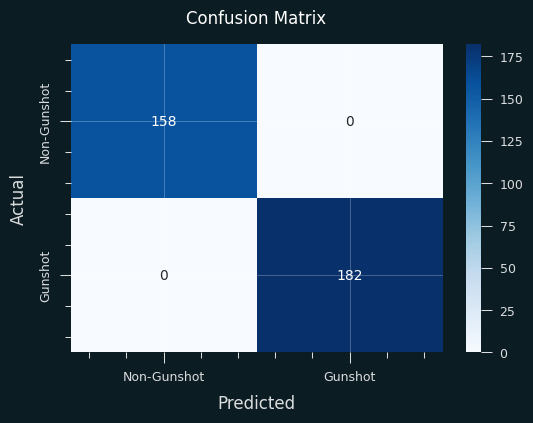

Classification Report:
              precision    recall  f1-score   support

 Non-Gunshot       1.00      1.00      1.00       158
     Gunshot       1.00      1.00      1.00       182

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340

Accuracy: 100.00%
Precision (Gunshot): 100.00%
Recall (Gunshot): 100.00%
F1-Score (Gunshot): 100.00%


In [25]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Gunshot', 'Gunshot'], 
            yticklabels=['Non-Gunshot', 'Gunshot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Non-Gunshot', 'Gunshot']))

# Calculate additional metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)  # Accuracy
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])   # Precision for Gunshot class
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])      # Recall for Gunshot class
f1_score = 2 * (precision * recall) / (precision + recall)  # F1-score for Gunshot class

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Gunshot): {precision * 100:.2f}%")
print(f"Recall (Gunshot): {recall * 100:.2f}%")
print(f"F1-Score (Gunshot): {f1_score * 100:.2f}%")

#### Model's evaluation

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 7.4506e-22
Test Accuracy: 100.00%


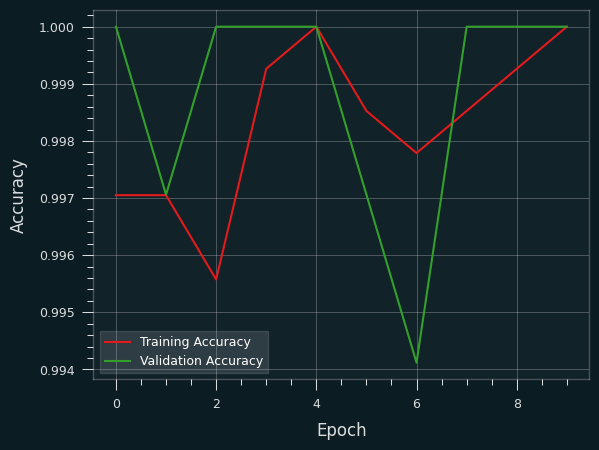

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Save the model

In [ ]:
# Save the model in .keras format
model.save("../models/spectral_neural_network.keras")